# About

- 시계열로 밀어붙이기에는 label 에 비해 상대적으로 너무 데이터가 적어서 학습하기가 힘들것 같다.
- 불균형 데이터의 Classification 으로 무언가 조치가 필요해 보인다.
- Upsampling 보다는 다양한 모델을 앙상블하는게 좋을듯
- 아... 무언가 획기적인 방법이 필요하다. 

1. 한 개의 행은 0.02초 (second)를 의미합니다. 즉 하나의 id 에 대해서 600개의 time 이 존재하므로  총 12초(0.02*600)동안의 동작을 측정한 것입니다.

2. 이 때에 가속계와, 자이로스코프는 오른쪽 forearm(전완) 에 착용하여 측정한 데이터입니다.

3. 가속도계는 해당 방향으로의 가속도(g)를, 자이로스코프는 해당 방향으로의 dps(degrees per second)를 측정한 것입니다.


- 우선 가속도 방향은 항상 중력방향으로 작용한다. 그러므로 운동을 하지 않을 때에도 어느정도는 계속 측정이 되고있는 상태이다.
- 그렇다면 가속도의 합을 
- 가속도를 이용해서 각 각도 등을 측정 가능할 것이다. 

- x 축 방향(-)은 손바닥 방향으로 추정된다.
- 플랭크 시에 0 이였던 점 , push up 떄에 -1 인점 을 보아 맞는듯 하다.
- 그리고 acc 의 범위는 9.8 N = 1 으로 추정된다.(Push up 때에 -1 -> 즉 지구 중력은 9.8)
- 같은 운동에 대해 x 축은 비슷한 분포를 보이는 반면 y,x 축은 약간 역전된 느낌이다.
- 이는 즉 측정 기구를 찰때 전완근에 차기 때문에 y,z 의 측정은 불안정해 보인다.
- 그러므로! x 만 하는게 좋아보인다.?

- Moving average 를 통해서 그 추이를 알아내는게 매우 큰 도움이 된다.
- min max 의 차이를 얻어내는게 큰 도움이 된다.

- 갑자기 올라가는 지점인 첨도가 높은 지점의 정보를 추가해야될듯

- 이동평균과, 원래 값을 빼서, noise 를 측정하자!

# Setting

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization,GRU, LSTM
import warnings
from scipy.signal import find_peaks

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

train=pd.read_csv('./data/train_features.csv')
train_labels=pd.read_csv('./data/train_labels.csv')
test=pd.read_csv('./data/test_features.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [2]:
def whole_table(ex,train_labels):
    df_ex = pd.DataFrame()
    for exer in train_labels['label_desc'].sort_values().unique() :
        val = np.mean(ex.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:],axis=0)
        df_ex = pd.concat([df_ex,pd.DataFrame(val,columns=[exer])],axis=1)
    return df_ex

In [3]:
def each_table(ex,train_labels,exer):
    each = ex.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:].T
    return each

In [4]:
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [5]:
#test'id'는 782개 
test['id'].nunique()

782

In [6]:
train_labels['label_desc'].unique()

array(['Shoulder Press (dumbbell)', 'Non-Exercise', 'Biceps Curl (band)',
       'Side Plank Right side', 'Plank', 'Chest Press (rack)',
       'Wall Squat', 'Russian Twist', 'Running (treadmill)',
       'Pushup (knee or foot variation)', 'Wall Ball',
       'Dynamic Stretch (at your own pace)',
       'Sit-up (hands positioned behind head)', 'Tap Right Device',
       'Static Stretch (at your own pace)', 'Device on Table',
       'Triceps extension (lying down)', 'Elliptical machine', 'Burpee',
       'Walking lunge', 'Lateral Raise', 'Jump Rope',
       'Triceps Kickback (knee on bench) (label spans both arms)',
       'Medicine Ball Slam',
       'Lunge (alternating both legs, weight optional)',
       'Fast Alternating Punches', 'Static stretch',
       'Squat Rack Shoulder Press', 'Overhead Triceps Extension',
       'Seated Back Fly', 'Bicep Curl', 'Side Plank Left side',
       'Dumbbell Squat (hands at side)', 'Dumbbell Deadlift Row',
       'Two-arm Dumbbell Curl (both arms, 

In [7]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [8]:
#782개의 id 별 동작 데이터를 활용해 각각의id가 어떤 동작인지를 분류하는 문제!!
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **데이터 살펴보기**

In [9]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
# 아 이거 너~ 무 불균형인데?
# Validation 이... 지금 그냥 다 0.5
train_labels['label_desc'].value_counts()

Non-Exercise                                                1518
Device on Table                                               97
Plank                                                         55
Wall Squat                                                    48
Jump Rope                                                     47
Two-arm Dumbbell Curl (both arms, not alternating)            37
Dip                                                           37
Tap Right Device                                              37
V-up                                                          36
Pushup (knee or foot variation)                               35
Lunge (alternating both legs, weight optional)                35
Burpee                                                        35
Shoulder Press (dumbbell)                                     35
Squat (arms in front of body, parallel to ground)             35
Overhead Triceps Extension                                    34
Sit-up (hands positioned 

In [10]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

- 데이터가 1422 개 이므로, 무조건 15개 내외로 변수를 짜야한다.
- 괜히 너무 col이 많아도 과적합됨.
- 어짜피 tree 모델인데.. 

- 어짜피 너무 불균형한 운동은 없다. 한쪽이 크면 음수쪽도 큼. 그러므로 max 면 충분할것
- 중요한건 acc 이다. 이게 중력의 영향때문에

- noise
    - 차이값이 중요 (이는 30 이동평균한 값을 이용해, 이와의 차이값을 이용하면 될듯)
    - 차이를 알게된다면 심하게 진동하는 값에 대한 measure 로 작용 가능
- diff
    - 최대와 최소의 차이가 중요
    - 어느정도 심하게 변하고 있는지에 대한 measure  가능
- change_x
    - 평균과 차이의 절댓값 합
    - 평균으로부터 얼마나 떨어지는가의 예시가됨.
- local maxima(30) 
    - 30 이동평균시에 로컬 maximum
    - acc, gy 2개의 값이 생긴다.
- mean
    - 각 값의 min 은 매우 중요하다
    - 모든 운동은 '대칭적' 으로 이루어진다는 점에서 그 mean 을 통해서 손목 기계의 위치가 달라질것
    - 다만 gy 의 mean 은 거의다 0이다. 즉 추가함의 의미가 없어보인다.
    
- quantile(0.8) 보다 큰 값에 대해, 이어지는 행렬의 갯수가 50개 이 


In [11]:
def plot(exercise,df,lis1,lis2) : # 각 운동(exersice) 에 대해서 df set 에 대해 lis1, lis2 에 해당하는 그래프를 그려준다.
    plt.figure(figsize= (25,20))
    plt.subplots_adjust(top = 3)
    for i in range(0,5) :
        plt.subplot(12,2,2*i+1)
        idx = random.choice(list(train_labels[train_labels['label_desc'] == exercise ]['id']))
        plt.plot(df[df['id']==idx].loc[:,lis1])
        plt.legend(lis1)
        plt.title(exercise)
        plt.subplot(12,2,2*i+2)
        plt.plot(df[df['id']==idx].loc[:,lis2])
        plt.legend(lis2)
        plt.title(exercise)

In [12]:
#for i in train_labels['label_desc'].unique() :
#    plot(i,train,['acc_x','acc_y','acc_z'],['gy_x','gy_y','gy_z'])

# EDA

## Noise

- 원래 데이터 - 31 이동평균 데이터 를 뺀 이후에 abs 를 한 이후게 얻은 값
- 이 때에 각 quanile 0.9,0.1 을 normalizing 하여서 그 높낮이 값에 대한 Noise 변화의 증감을 낮췄다.
- 즉 이 값은 순수한 Noise의 크기 합을 나타낸다.

In [13]:
def moving(train):
    df_train = train
    df_train['index']= df_train.index
    df_train1 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(3,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_train2 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(31,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_new = pd.merge(df_train, df_train2, on='index')
    df_new.drop(columns=['id_y','time','index'],inplace = True)
    def quant(x):
        val1 = np.quantile(x,0.9)
        val2 = np.quantile(x,0.1)
        return(val1-val2)
    df_noise= df_new[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values - df_new[['acc_x_y', 'acc_y_y', 'acc_z_y', 'gy_x_y', 'gy_y_y', 'gy_z_y']].values
    normalize = df_new.groupby('id_x').agg(quant)[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values
    df_noise = pd.DataFrame(df_noise,columns=['noise_acc_x', 'noise_acc_y', 'noise_acc_z', 'noise_gy_x', 'noise_gy_y', 'noise_gy_z'])
    df_noise = pd.concat([df_new['id_x'],df_noise],axis=1)
    df_noise = np.abs(df_noise)
    df_noise = df_noise.groupby('id_x').agg(sum)
    df_noise = df_noise/ normalize
    df = df_noise
    df.reset_index(inplace = True,drop= True)
    return df, df_train, df_train1, df_train2

In [14]:
df,df_train,df_train1,df_train2 = moving(train)

## Local maximum

- train_2 (center 을 True 로 한 이동평균) 데 애해서, local maximum 의 수를 센다.
- 노이즈가 매우 많은 경우 큰 값을 나타나게 된다.

In [15]:
def Local(df,train):    
    def pick(x) :
        val = len(find_peaks(x)[0])
        return val
    ex = train.groupby('id').agg(pick) # id 를 기준으로 한다.
    df_local = ex.iloc[:,1:].reset_index(drop=True)
    df_local.columns = ['local_acc_x', 'local_acc_y', 'local_acc_z', 'local_gy_x', 'local_gy_y', 'local_gy_z']
    df = pd.concat([df,df_local],axis=1)
    return df

In [16]:
df = Local(df,df_train2)
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0


## Diff

- 3 이동평균을 제안한 값에 대하여, 최대값과 최소값의 차이를 조사한다.
- 그럴 경우 큰 차이가 난다면, 가동범위가 매우 크다는것을 의미한다.

In [17]:
def Diff(df, train):
    df_diff = train.groupby('id').max().iloc[:,1:] - train.groupby('id').min().iloc[:,1:]
    df_diff = df_diff.reset_index().iloc[:,1:]
    df_diff.columns = ['dif_acc_x', 'dif_acc_y', 'dif_acc_z', 'dif_gy_x', 'dif_gy_y', 'dif_gy_z']
    df = pd.concat([df,df_diff],axis=1)
    return(df)

In [18]:
df = Diff(df,df_train1)

In [19]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151


## Mean

- mean 은 3 평균을 취한 train1 에서부터 진행하자

In [20]:
def Mean(df,train) :
    df_mean = train.groupby('id').mean().reset_index().iloc[:,2:5]
    df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z']
    df = pd.concat([df,df_mean],axis=1)
    return(df)

In [21]:
df = Mean(df,df_train1)

In [22]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937,0.930537,-0.218199,-0.370759
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801,-0.768685,-0.317827,-0.007082
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089,0.039977,-0.081698,0.625277
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133,-0.887508,-0.086825,0.228431
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932,-0.659146,-0.335625,0.204839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522,-0.301425,-0.668834,0.335230
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650,-0.974954,-0.233618,-0.073695
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547,-1.112687,-0.361795,0.241552
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151,-0.109792,0.881698,-0.121676


## Dif_Mean

- Dif_Mean 은 평균을 취한 값과 그 차이를 계산한다

In [23]:
def Dif_Mean(df,train):
    train = train.iloc[:,:-1]
    df_temp = train.groupby('id').transform(np.mean).iloc[:,1:]
    df_mean = train[['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']] - df_temp
    df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'mean_gy_x', 'mean_gy_y', 'mean_gy_z']
    df_temp = pd.concat([train[['id']],df_mean],axis=1)
    df_temp = np.abs(df_temp)
    df_mean = df_temp.groupby('id').sum()
    df_mean = df_mean.reset_index(drop=True)
    df_mean.columns =['dif_mean_acc_x', 'dif_mean_acc_y', 'dif_mean_acc_z', 'dif_mean_gy_x', 'dif_mean_gy_y','dif_mean_gy_z']
    df = pd.concat([df,df_mean],axis=1)
    return(df)

In [24]:
df = Dif_Mean(df,train)

In [25]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607


## Big

- Big 이란 Threshold 가 acc는1, 각도는100 이상의 갑작스런 변환이다.

In [51]:
def Big(df,train):
    def maxi_ac(x) :
        val = len(find_peaks(x,threshold=1)[0])
        return val
    def maxi_gy(x) :
        val = len(find_peaks(x,threshold=100)[0])
        return val
    ex = train.groupby('id').agg(maxi_ac)[['acc_x','acc_y','acc_z']]
    ex2 = train.groupby('id').agg(maxi_gy)[['gy_x','gy_y','gy_z']]
    df['big']= np.array(np.array(np.sum(ex,axis=1) + np.sum(ex2,axis=1)))
    return(df)

In [27]:
Big(df,train)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,0.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,0.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,0.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,0.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,0.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,0.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,5.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607,0.0


# 모델링 준비

## y 준비

In [28]:
y = train_labels['label'].copy()
X = df.copy()

## Split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0,stratify=y)

## Upsampling

In [31]:
temp = train_labels['label'].value_counts() * 4
dic = dict(zip(temp.index,temp.values))

In [32]:
dic[26] = 1400

In [33]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
X_samp, y_samp = ADASYN(random_state=0,sampling_strategy=dic).fit_sample(X_train, y_train)

In [34]:
X_train = X_samp
y_train = y_samp


# **모델링**

## XGB

In [35]:
import xgboost as xgb
from xgboost import XGBClassifier

In [36]:
model = XGBClassifier(n_estimators=1000, 
                      learning_rate=0.05,
                      max_leaves = 300,
                      subsample = 0.5,
                      colsample_bytree = 0.5,
                      booster = 'dart',
                     eval_metric = "mlogloss")

In [236]:
model.fit(X_train,y_train,
         eval_set = [(X_val,y_val)], # evaluate 할 셋
         verbose = 50, # 언제마다 보여줄지
         early_stopping_rounds= 300
          # 언제 학습이 끝나는 기준을 잡을지
         )

[0]	validation_0-mlogloss:3.57386
Will train until validation_0-mlogloss hasn't improved in 300 rounds.
[50]	validation_0-mlogloss:1.16309
[100]	validation_0-mlogloss:0.87199
[150]	validation_0-mlogloss:0.79601
[200]	validation_0-mlogloss:0.77708
[250]	validation_0-mlogloss:0.77331
[300]	validation_0-mlogloss:0.77613
[350]	validation_0-mlogloss:0.77876


KeyboardInterrupt: 

## LGBM

In [59]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [60]:
#d_train 시에는 아래와 같이 d_train 의 형태로 바꾸어 주어야 한다.
model = LGBMClassifier(objective = 'multi_logloss',
                       metric = 'multi_logloss',
                       boosting ='dart',
                       drop_rate = 0.5,
                       n_estimators= 400,
                       learning_rate= 0.1,
                       min_data_in_leaf = 400,
                       bagging_fraction = 0.5,
                       feature_fraction = 0.5,
                       max_depth = 6,
                       seed = 42)

In [61]:
model.fit(X_train,y_train,
         eval_set = (X_val,y_val), # evaluate 할 셋
         verbose = 50, # 언제마다 보여줄지
         early_stopping_rounds= 100 # 언제 학습이 끝나는 기준을 잡을지
         )

[50]	valid_0's multi_logloss: 1.58606
[100]	valid_0's multi_logloss: 1.31824
[150]	valid_0's multi_logloss: 1.13401
[200]	valid_0's multi_logloss: 0.869632
[250]	valid_0's multi_logloss: 0.83228
[300]	valid_0's multi_logloss: 0.78457
[350]	valid_0's multi_logloss: 0.755255
[400]	valid_0's multi_logloss: 0.754023


LGBMClassifier(bagging_fraction=0.5, boosting='dart', drop_rate=0.5,
               feature_fraction=0.5, max_depth=6, metric='multi_logloss',
               min_data_in_leaf=400, n_estimators=400,
               objective='multi_logloss', seed=42)

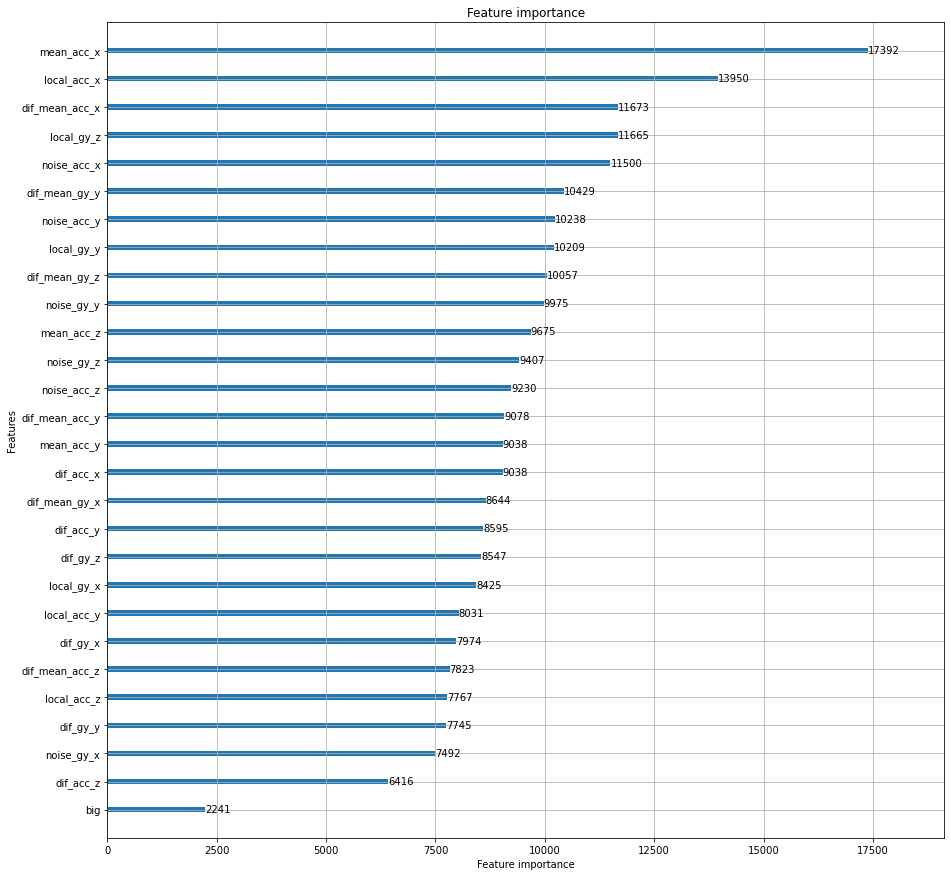

In [62]:
ax = lgb.plot_importance(model, max_num_features=80, figsize=(15,15))
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
q = pd.DataFrame(range(0,61),columns=['label'])

In [65]:
idx = np.array(pd.merge(q,train_labels[['label','label_desc']],on='label').drop_duplicates()['label_desc'])

In [68]:
from sklearn.metrics import classification_report

class_name = idx
print( classification_report(y_val,model.predict(X_val), target_names= class_name ) )

                                                          precision    recall  f1-score   support

                                     Arm Band Adjustment       0.00      0.00      0.00         2
                                      Band Pull-Down Row       0.75      0.75      0.75         4
                                              Bicep Curl       0.50      0.50      0.50         4
                                      Biceps Curl (band)       0.60      0.60      0.60         5
                                                  Burpee       1.00      0.86      0.92         7
                                        Butterfly Sit-up       0.83      1.00      0.91         5
                                      Chest Press (rack)       0.40      0.80      0.53         5
                                                  Crunch       0.75      0.60      0.67         5
                                         Device on Table       0.91      1.00      0.95        20
                   

In [69]:
confusion= pd.DataFrame(confusion_matrix(y_val, model.predict(X_val)),columns = idx)

In [70]:
confusion.index = idx

In [71]:
confusion

,Arm Band Adjustment,Band Pull-Down Row,Bicep Curl,Biceps Curl (band),Burpee,Butterfly Sit-up,Chest Press (rack),Crunch,Device on Table,Dip,Dumbbell Deadlift Row,Dumbbell Row (knee on bench) (label spans both arms),Dumbbell Row (knee on bench) (left arm),Dumbbell Row (knee on bench) (right arm),Dumbbell Squat (hands at side),Dynamic Stretch (at your own pace),Elliptical machine,Fast Alternating Punches,Jump Rope,Jumping Jacks,Kettlebell Swing,Lateral Raise,Lawnmower (left arm),Lawnmower (right arm),"Lunge (alternating both legs, weight optional)",Medicine Ball Slam,Non-Exercise,Overhead Triceps Extension,Plank,Power Boat pose,Pushup (knee or foot variation),Pushups,Repetitive Stretching,Rowing machine,Running (treadmill),Russian Twist,Seated Back Fly,Shoulder Press (dumbbell),Side Plank Left side,Side Plank Right side,Sit-up (hands positioned behind head),Sit-ups,Squat,"Squat (arms in front of body, parallel to ground)",Squat (hands behind head),Squat (kettlebell / goblet),Squat Jump,Squat Rack Shoulder Press,Static Stretch (at your own pace),Static stretch,Tap Right Device,Triceps Kickback (knee on bench) (label spans both arms),Triceps Kickback (knee on bench) (left arm),Triceps Kickback (knee on bench) (right arm),Triceps extension (lying down),"Two-arm Dumbbell Curl (both arms, not alternating)",V-up,Walk,Walking lunge,Wall Ball,Wall Squat
Arm Band Adjustment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Band Pull-Down Row,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bicep Curl,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Biceps Curl (band),0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Burpee,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Butterfly Sit-up,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chest Press (rack),0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Crunch,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Device on Table,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dip,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 제출

## 최종 Upsampling

In [40]:
temp = train_labels['label'].value_counts() * 5
dic = dict(zip(temp.index,temp.values))

In [41]:
dic[26] = 1700

In [42]:
len(y.unique())

61

In [43]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
X_samp, y_samp = ADASYN(random_state=0,sampling_strategy=dic).fit_sample(X, y)

## 최종 fitting

In [44]:
#d_train 시에는 아래와 같이 d_train 의 형태로 바꾸어 주어야 한다.
model = LGBMClassifier(objective = 'multi_logloss',
                       metric = 'multi_logloss',
                       boosting ='dart',
                       drop_rate = 0.5,
                       n_estimators= 450,
                       learning_rate= 0.1,
                       min_data_in_leaf = 400,
                       bagging_fraction = 0.5,
                       feature_fraction = 0.5,
                       max_depth = 6,
                       seed = 42)
model.fit(X_samp,y_samp,verbose = 50) 

LGBMClassifier(bagging_fraction=0.5, boosting='dart', drop_rate=0.5,
               feature_fraction=0.5, max_depth=6, metric='multi_logloss',
               min_data_in_leaf=400, n_estimators=450,
               objective='multi_logloss', seed=42)

## Test set 변환

In [45]:
df_,df_test,df_test1,df_test2 = moving(test)

In [46]:
df_ = Local(df_,df_test2)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0


In [47]:
df_ = Diff(df_,df_test1)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559


In [48]:
df_ = Mean(df_,df_test1)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390


In [49]:
df_ = Dif_Mean(df_,test)

In [50]:
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095


In [52]:
Big(df_,test)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105,0.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660,0.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946,0.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877,0.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771,0.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173,0.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142,0.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095,0.0


In [53]:
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105,0.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660,0.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946,0.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877,0.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771,0.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173,0.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142,0.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095,0.0


## Prediction

In [54]:
prediction=model.predict_proba(df_)

In [55]:
prediction.shape

(782, 61)

In [56]:
submission.iloc[:,1:]=prediction

In [57]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000359,0.000207,0.000132,0.000657,0.000122,0.000086,0.000521,0.000114,0.000207,0.046496,0.021146,0.002549,0.000211,0.419773,0.018815,0.001281,0.000114,0.000087,0.000087,0.000076,0.000085,0.000157,0.000193,0.000081,0.391589,0.000084,0.008457,0.000224,0.000083,0.000735,0.000670,0.003664,0.002005,0.000135,0.004700,0.000087,0.006284,0.012487,0.000108,0.000393,0.000182,0.000072,0.000578,0.000336,0.000209,0.000273,0.000141,0.000657,0.000251,0.000847,0.000216,0.011145,0.002222,0.000467,0.000177,0.000144,0.000099,0.000843,0.030420,0.000073,0.005385
1,3126,0.000146,0.000064,0.000157,0.000661,0.000053,0.001825,0.000103,0.000280,0.000067,0.000217,0.000152,0.000211,0.000048,0.000064,0.000063,0.000398,0.000071,0.000052,0.000118,0.000050,0.000128,0.000267,0.000144,0.009592,0.000089,0.000087,0.973142,0.000182,0.000079,0.000050,0.000078,0.000051,0.000703,0.000088,0.000067,0.000649,0.000122,0.000096,0.000051,0.000050,0.002903,0.000213,0.000156,0.000077,0.000050,0.000190,0.000066,0.000086,0.000411,0.003757,0.000135,0.000289,0.000058,0.000090,0.000139,0.000220,0.000113,0.000072,0.000057,0.000051,0.000354
2,3127,0.004312,0.033960,0.000128,0.000478,0.000111,0.000161,0.005291,0.000395,0.000565,0.001124,0.001032,0.000225,0.000958,0.000162,0.002661,0.006892,0.000175,0.000330,0.000379,0.000103,0.000126,0.000317,0.000775,0.000125,0.000375,0.000108,0.211227,0.000770,0.000124,0.000110,0.000563,0.000164,0.319268,0.000389,0.000714,0.000481,0.000799,0.000373,0.001746,0.000132,0.001450,0.000687,0.000166,0.002096,0.000675,0.008943,0.000134,0.002757,0.337507,0.025072,0.000345,0.000165,0.000095,0.000133,0.002076,0.000142,0.000324,0.000409,0.000118,0.002214,0.016361
3,3128,0.000096,0.000039,0.000081,0.000446,0.000034,0.000233,0.000036,0.000096,0.000042,0.000048,0.000050,0.000043,0.000031,0.000270,0.000039,0.000225,0.000044,0.000033,0.000035,0.000035,0.000040,0.000433,0.000036,0.002720,0.000265,0.000035,0.975399,0.000744,0.000089,0.000032,0.000069,0.000040,0.000953,0.000035,0.000040,0.000128,0.000088,0.000058,0.000036,0.000037,0.000048,0.000079,0.004616,0.000112,0.000037,0.000062,0.000068,0.000050,0.000310,0.000958,0.000559,0.000243,0.000075,0.000140,0.000194,0.000120,0.000067,0.002673,0.000038,0.000034,0.006285
4,3129,0.001759,0.000094,0.000039,0.000085,0.000041,0.000046,0.000084,0.000042,0.000197,0.000181,0.000048,0.000136,0.000041,0.000043,0.000039,0.000270,0.000041,0.000034,0.000043,0.000034,0.000034,0.000047,0.000424,0.000041,0.000065,0.000073,0.973401,0.000038,0.000037,0.000034,0.000061,0.000037,0.005730,0.000046,0.000187,0.000094,0.000084,0.000072,0.000038,0.000040,0.000108,0.000039,0.000054,0.000094,0.000037,0.000035,0.000044,0.000034,0.001835,0.003676,0.009326,0.000171,0.000035,0.000063,0.000054,0.000052,0.000064,0.000140,0.000039,0.000046,0.000176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.000461,0.000144,0.000051,0.000442,0.016275,0.000170,0.000130,0.000059,0.000107,0.001369,0.000191,0.002401,0.000056,0.000108,0.000061,0.003229,0.000051,0.000103,0.031508,0.000060,0.000056,0.000085,0.000575,0.000099,0.000392,0.000052,0.904099,0.000092,0.000104,0.000044,0.000281,0.000378,0.007460,0.000212,0.021625,0.000112,0.000247,0.000059,0.000121,0.000059,0.000567,0.000167,0.000121,0.000072,0.000052,0.000081,0.000046,0.000074,0.000493,0.001687,0.000617,0.001404,0.000127,0.000118,0.000078,0.000059,0.000075,0.000757,0.000107,0.000069,0.000103
778,3903,0.000093,0.000055,0.000111,0.000415,0.000283,0.000517,0.000033,0.000052,0.000050,0.000049,0.000088,0.000140,0.000031,0.000118,0.000037,0.002614,0.000042,0.000033,0.000038,0.000074,0.000097,0.000102,0.000036,0.000611,0.000087

In [58]:
submission.to_csv('./Submission/hanadool_4.csv', index=False)